The following is the notebook of code written by H. Passmore for the assessment and tuning of Machine Learning algorithms for Capstone 1: Amazon Book Reviews & Ratings Predictor. 

# Machine Learning Algorithms for Capstone 1
_Amazon Book Reviews & Ratings Predictor_

_Machine Learning Code_
***

### Below is the code for assessing and tuning machine learning algorithms to predict ratings from reviews.

In [1]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import norm
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm

# Build figures inline
%matplotlib inline

In [2]:
# Setup Pandas  
pd.set_option('display.width', 350)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("talk")

In [3]:
# bring the book_revs dataframe into workspace from the inferential statistics code
# import pickle
# load the pickled  DataFrame of Science Textbook Reviews from hard drive in 'rb' mode
import pickle
with open('book_revs_forML.pickle','rb') as f:
    book_revs = pickle.load(f)

### Check dataframe of ratings and review text

In [4]:
# check input data for Machine Learning: reviewText and rating_cat
book_revs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11546 entries, 0 to 11545
Data columns (total 9 columns):
asin           11546 non-null object
overall        11546 non-null int64
reviewText     11546 non-null object
summary        11546 non-null object
five_not5      11546 non-null object
rating_cat     11546 non-null int64
token_count    11546 non-null int64
caps_count     11546 non-null int64
pct_caps       11546 non-null float64
dtypes: float64(1), int64(4), object(4)
memory usage: 811.9+ KB


In [6]:
# keep only what we need
rev_rate = book_revs.drop(['asin', 'overall', 'summary', 'five_not5', 'token_count', 'caps_count', 'pct_caps'], axis=1)
rev_rate.head(2)

,reviewText,rating_cat
0,This is a good book for the science nerd and t...,0
1,"If you're a biology/genetics enthusiast, this ...",1


## Implement tools to Reduce Document Dimensions

In [7]:
# Implement WordNetLemmatizer and build CountVectorizer with tokenizer and lemmatizer
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from nltk.stem.snowball import SnowballStemmer

In [11]:
import string
user_defined_stop_words = ['book', 'books', 'read', 'reading']

i = stopwords.words('english')
j = list(string.punctuation) + user_defined_stop_words

stopwords = set(i).union(j)

In [13]:
# define preprocessor
def preprocess(x):
    x = re.sub('[^a-z\s]', '', x.lower())                   # get rid of noise
    x = [w for w in x.split() if w not in set(stopwords)]   # remove stopwords
    return ' '.join(x)

In [14]:
# apply preprocessor to review text
rev_rate['clean_revs'] = rev_rate['reviewText'].apply(preprocess)
rev_rate.tail()

,reviewText,rating_cat,clean_revs
11541,Definitely a MUST-READ if you are a home cooki...,1,definitely mustread home cooking enthusiast wa...
11542,Pros: Scientifically informative and solid. Kn...,0,pros scientifically informative solid knowing ...
11543,Real fun to read. For everybody that is inters...,0,real fun everybody intersted cooking certain p...
11544,This book will teach you the chemical secrets ...,0,teach chemical secrets techniques usually used...
11545,I paid more than $30 to buy such a superficial...,0,paid buy superficial trivial made big mistake ...


In [28]:
# instantiate the lemmatizer & stemmer
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english", ignore_stopwords=True)

from nltk import pos_tag

In [29]:
# define second preprocessor for tokenization and lemmatization
def preprocess2(text):
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    tokens = word_tokenize(text)
    stems = [stemmer.stem(t) for t in tokens]
    return stems

In [30]:
rev_rate['clean_revs'].apply(preprocess2)
rev_rate.tail()

,reviewText,rating_cat,clean_revs
11541,Definitely a MUST-READ if you are a home cooki...,1,definitely mustread home cooking enthusiast wa...
11542,Pros: Scientifically informative and solid. Kn...,0,pros scientifically informative solid knowing ...
11543,Real fun to read. For everybody that is inters...,0,real fun everybody intersted cooking certain p...
11544,This book will teach you the chemical secrets ...,0,teach chemical secrets techniques usually used...
11545,I paid more than $30 to buy such a superficial...,0,paid buy superficial trivial made big mistake ...


## Create X & y, split train and test data sets

In [31]:
# store the feature matrix (X) and response vector (y) 
# uppercase X because it's an m x n matrix
X = rev_rate.clean_revs

# lowercase y because it's a m x 1 vector
y = rev_rate.rating_cat

print(X.shape)
print(y.shape)

(11546,)
(11546,)


In [32]:
# split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Show the results of the split
print("X Training set sample size:", (X_train.shape[0]))
print("X Testing set sample size:", (X_test.shape[0]))
print("y Training set sample size:", (y_train.shape[0]))
print("y Testing set sample size:", (y_test.shape[0]))

X Training set sample size: 8659
X Testing set sample size: 2887
y Training set sample size: 8659
y Testing set sample size: 2887


In [33]:
# Double check stratification
print(np.mean(y_train == 0))
print(np.mean(y_test == 0))

0.336412980714
0.336335296155


## Vectorize, fit, output document-term matrix with two vectorizers

In [34]:
# import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# instantiate two vectorizers
vect = CountVectorizer(stop_words='english') 
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)

# Apply CountVectorizer to lemmatized tokens to learn training data vocabulary
# then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train.values)

# examine the document-term matrix
X_train_dtm

<8659x45833 sparse matrix of type '<class 'numpy.int64'>'
	with 410807 stored elements in Compressed Sparse Row format>

In [35]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test.values)
X_test_dtm

<2887x45833 sparse matrix of type '<class 'numpy.int64'>'
	with 127559 stored elements in Compressed Sparse Row format>

In [37]:
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)

In [38]:
# Apply TfidfVectorizer to learn training data vocabulary
# then use it to create a document-term matrix
X_train_tfidf = tfidf.fit_transform(X_train.values)

# examine the document-term matrix
X_train_tfidf

<8659x45833 sparse matrix of type '<class 'numpy.float64'>'
	with 410807 stored elements in Compressed Sparse Row format>

In [39]:
# transform testing data with tfidif vectorizer with lemmatizer into document-term matrix
X_test_tfidf = tfidf.transform(X_test.values)
X_test_tfidf

<2887x45833 sparse matrix of type '<class 'numpy.float64'>'
	with 127559 stored elements in Compressed Sparse Row format>

## First, build the simple model with Naive Bayes for baseline

In [40]:
# import and instantiate scikit-learn's MultinomialNB() classifier with default parameters
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [41]:
# train the model using X_train_dtm from CountVectorizer (vect)
%time nb.fit(X_train_dtm, y_train)

CPU times: user 13.8 ms, sys: 17.2 ms, total: 31 ms
Wall time: 33.8 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [47]:
# COMPARE TFIDF VECTORIZER
# train the model using X_train_tfidf from TfidfVectorizer
%time nb.fit(X_train_tfidf, y_train)

CPU times: user 18.1 ms, sys: 13.6 ms, total: 31.7 ms
Wall time: 30.6 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [42]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

# calculate accuracy of class predictions
from sklearn import metrics

# calculate F1 Score: a weighted average of the precision and recall (est value at 1 and worst score at 0)
metrics.f1_score(y_test, y_pred_class)

0.8125148139369518

In [48]:
# COMPARE TFIDF VECTORIZER
# make class predictions for X_test_dtm
y_pred_tfidf = nb.predict(X_test_tfidf)

# calculate F1 Score: a weighted average of the precision and recall (est value at 1 and worst score at 0)
metrics.f1_score(y_test, y_pred_tfidf)

0.80016722408026753

In [43]:
# print the confusion matrix from Count Vectorizer
metrics.confusion_matrix(y_test, y_pred_class)

array([[ 382,  589],
       [ 202, 1714]])

In [49]:
# COMPARE TFIDF VECTORIZER
# print the confusion matrix from Count Vectorizer
metrics.confusion_matrix(y_test, y_pred_tfidf)

array([[  17,  954],
       [   2, 1914]])

Confusions Matrix breakdown for TFIDF Vectorizer with Naive Bayes:
True Positives: 1914 reviews correctly predicted as 'five'
True Negatives: 17 reviews correctly predicted as 'not5'
False Positives: 954 reviews incorrectly predicted to be 'five' but they are 'not5' (Type I error).
False Negatives: 2 reviews incorrectly predicted to be 'not5' but they are 'five' (Type II error).

In [44]:
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([ 0.97053121,  0.9800439 ,  0.18085417, ...,  0.99049046,
        0.99517813,  0.99859609])

In [50]:
# COMPARE TFIDF VECTORIZER
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob_tfidf = nb.predict_proba(X_test_tfidf)[:, 1]
y_pred_prob_tfidf

array([ 0.89661637,  0.8431404 ,  0.51840247, ...,  0.9475545 ,
        0.89319634,  0.90023854])

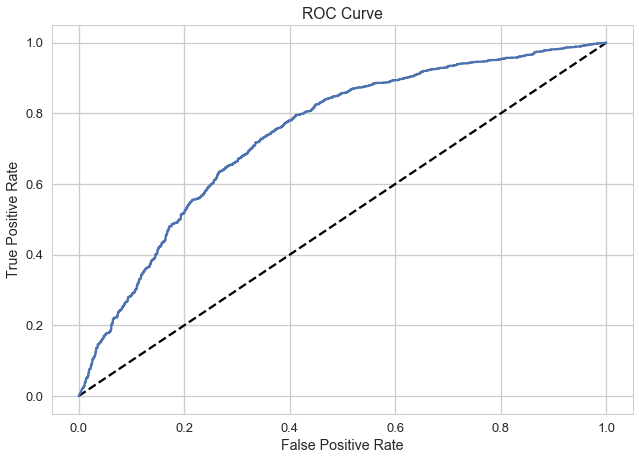

In [45]:
# Import roc_curve module
from sklearn.metrics import roc_curve

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [46]:
# calculate AUC for simple model
metrics.roc_auc_score(y_test, y_pred_prob)

0.74103489719614102

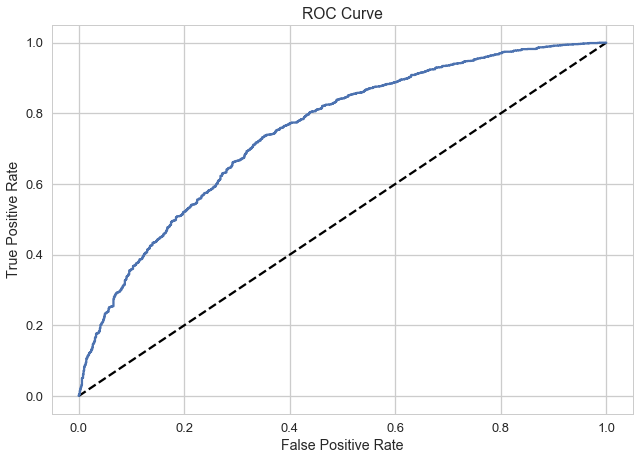

In [51]:
# COMPARE TFIDF VECTORIZER
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_tfidf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [52]:
# COMPARE TFIDF VECTORIZER
# calculate AUC for simple model
metrics.roc_auc_score(y_test, y_pred_prob_tfidf)

0.74864010371762324

### Run GridSearchCV on best vectorizer & classifier to pick parameters

In [60]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# create a list of performace parameters for performace tuning (ngram range, use idf?, best alpha)
parameters = {#'ngram_range': [(1, 1), (1, 2), (1,3)], 
              #'max_df': (0.5, 0.75, 1.0),
              #'vect__max_features': [1, 3, 10],
              #'min_df' :(0.00001,0.0001,0.001,0.01,1),
              #'fit_prior': (True, False),
              #'class_prior': (True, False), 
              'alpha': (0.001, 0.1, 1, 5, 10)
             }
        

In [57]:
# run this to get a list of the all available pipe-items unique keys for the grid parameters
sorted(nb.get_params().keys())

['alpha', 'class_prior', 'fit_prior']

In [61]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.

gs_mnb = GridSearchCV(nb, parameters, scoring='roc_auc', n_jobs=-1)
gs_mnb = gs_mnb.fit(X_train_dtm, y_train)

In [62]:
# View the best accuracy score
print('Best score for text:', gs_mnb.best_score_) 

Best score for text: 0.737147512875


In [63]:
# Get best parameters
print('Best parameters:', gs_mnb.best_params_)
# Alpha = 1 is the default and picked as best alpha

Best parameters: {'alpha': 1}


## Examine model inputs for further insight

In [ ]:
# store the vocabulary of X_train
X_train_tokens = vect.get_feature_names()
len(X_train_tokens)

In [ ]:
# examine the first 50 tokens
print(X_train_tokens[0:50])

In [ ]:
# examine the last 50 tokens
print(X_train_tokens[-50:])

__Interpretation of simple model:__ The Naive Bayes model with all training tokens performs okay, but it is obvious that some of the terms in the document terms matrix are uninformative (see the list of the first 50 tokens). Many of these will be taken care of when we use GridSearchCV to determine the minimum document frequency for tokens. Further, even the list of the last 50 tokens includes words that would be consolidated to one root work with stemming. In the next steps I will implement NLTK's SnowballStemmer as well as identify the best parameters with GridSearchCV.

In [ ]:
# counting number of words in each doc gives more weight to long docs over short docs
# instantiate TF-IDF, fit & transform training document term matrix
# get dimensions of new Document-Term Matrix (it is the same as shape of X_train_dtm. Should it be different?)
from sklearn.feature_extraction.text import TfidfVectorizer # I get an error "lower not found" when I used this
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_dtm)
X_train_tfidf.shape

## Build & evaluate pipeline with stemmed vectorizer, TFIDF transformer, & Multinomial Naive Bayes Classifier

In [ ]:
# Build a pipeline with the SnowballStemmer & TF-IDF Transformer
from sklearn.pipeline import Pipeline

text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect), ('tfidf', TfidfTransformer()), 
                             ('mnb', MultinomialNB(fit_prior=False))])

text_mnb_stemmed = text_mnb_stemmed.fit(X_train, y_train)

predicted_mnb_stemmed = text_mnb_stemmed.predict(X_test)

np.mean(predicted_mnb_stemmed == y_test)

In [ ]:
# calculate F1 Score: a weighted average of the precision and recall (est value at 1 and worst score at 0)
metrics.f1_score(y_test, predicted_mnb_stemmed) # I need estimated targets as returned by a classifier

In [ ]:
# print the confusion matrix
metrics.confusion_matrix(y_test, predicted_mnb_stemmed)

Confusions Matrix breakdown:
True Positives: 1851 reviews correctly predicted as 'five'
True Negatives: 195 reviews correctly predicted as 'not5'
False Positives: 776 reviews incorrectly predicted to be 'five' but they are 'not5' (Type I error).
False Negatives: 65 reviews incorrectly predicted to be 'not5' but they are 'five' (Type II error).

Progress: My True Positive count increased from the Naive Bayes model, but my True Negatives decreased.

In [ ]:
# print the classification report for stemmed Multinomial Naive Bayes model
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_mnb_stemmed))

In [ ]:
# calculate predicted probabilities for X_test with stemmed MNB model
y_pred_prob_mnb_stemmed = text_mnb_stemmed.predict_proba(X_test)[:, 1]
y_pred_prob_mnb_stemmed

In [ ]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_mnb_stemmed)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
# calculate AUC for stemmed mnb model
metrics.roc_auc_score(y_test, y_pred_prob_mnb_stemmed)

In [ ]:
# DID NOT RUN. PRIOR RUN OF NGRAM_RANGE -> (1,1) WHICH PARAMETERS ARE IMPORTANT?
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# create a list of performace parameters for performace tuning (ngram range, use idf?, best alpha)
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1,3)]} 
              #'vect__max_df': (0.5, 0.75, 1.0),
              #'vect__max_features': [1, 3, 10],
              #'vect__min_df' :(0.00001,0.0001,0.001,0.01,1),
              #'tfidf__use_idf': (True, False), 
              #'mnb__alpha': (0.1, 1, 5, 10)}
            
# Note: the fitting step takes way too long. 10 minutes for just ngrams. Need to fix this.

In [ ]:
# run this to get a list of the all available pipe-items unique keys for the grid parameters
#sorted(text_mnb_stemmed.get_params().keys())

In [ ]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.

gs_mnb_stem = GridSearchCV(text_mnb_stemmed, parameters, n_jobs=-1)
gs_mnb_stem = gs_mnb_stem.fit(X_train, y_train)

In [ ]:
# View the best accuracy score
print('Best score for text:', gs_mnb_stem.best_score_) 
# prior run gave: Best score for text: 0.7037764176

In [ ]:
# Get best parameters
print('Best parameters:', gs_mnb_stem.best_params_)
# prior run with just ngram_range in grid gave: Best parameters: {'vect__ngram_range': (1, 1)}

## Build pipeline to fit Random Forest classifier, get feature importance

In [ ]:
# import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# classifier pipeline
text_rf_stemmed = Pipeline([('vect', stemmed_count_vect), ('tfidf', TfidfTransformer()), 
                             ('rf', RandomForestClassifier())])

text_rf_stemmed = text_rf_stemmed.fit(X_train, y_train)

predicted_rf_stemmed = text_rf_stemmed.predict(X_test)

metrics.accuracy_score(y_test, predicted_rf_stemmed)

In [ ]:
# calculate F1 Score: a weighted average of the precision and recall (est value at 1 and worst score at 0)
metrics.f1_score(y_test, predicted_rf_stemmed) # I need estimated targets as returned by a classifier

In [ ]:
# print the confusion matrix These changed on a new run. Do I need to set random state?
metrics.confusion_matrix(y_test, predicted_rf_stemmed)

Confusions Matrix breakdown:
True Positives: 1622 reviews correctly predicted as 'five'
True Negatives: 390 reviews correctly predicted as 'not5'
False Positives: 581 reviews incorrectly predicted to be 'five' but they are 'not5' (Type I error).
False Negatives: 294 reviews incorrectly predicted to be 'not5' but they are 'five' (Type II error).

Progress: My True Positive count decreased from the stemmed Naive Bayes model, but my True Negatives increased.

In [ ]:
# print the classification report for stemmed Random Forest model
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_rf_stemmed))

In [ ]:
# calculate predicted probabilities for X_test with stemmed MNB model
y_pred_prob_rf_stemmed = text_rf_stemmed.predict_proba(X_test)[:, 1]
y_pred_prob_rf_stemmed

In [ ]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf_stemmed)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
# calculate AUC for stemmed randomforest model
metrics.roc_auc_score(y_test, y_pred_prob_rf_stemmed)

In [ ]:
# use to get a list of the all available pipe-items unique keys for the grid parameters
#sorted(text_rf_stemmed.get_params().keys())

In [ ]:
# find best parameters with GridSearchCV
# create a list of performace parameters for performace tuning (ngram range, use idf?, best alpha)
params = {'vect__ngram_range': [(1, 1), (1, 2), (1,3)], 
              #'vect__max_df': (0.5, 0.75, 1.0),
              'vect__max_features': [1, 3, 10],
              #'vect__min_df' :(0.00001,0.0001,0.001,0.01,1),
              #'rf__min_samples_leaf': (1, 3, 10),
              #'rf__min_samples_split': (1, 3, 10),
              #'tfidf__use_idf': (True, False), 
              #'mnb__alpha': (0.1, 1, 5, 10)
         }

#Note: Took 15 minutes to run just ngrams & max features. best parameters = max feat, 1, ngram (1,1)

In [ ]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.

gs_rf_stem = GridSearchCV(text_rf_stemmed, params, n_jobs=-1)
gs_rf_stem = gs_rf_stem.fit(X_train, y_train) # this is the slow step

In [ ]:
# View the best accuracy score
print('Best score for text:', gs_rf_stem.best_score_) 
# prior run gave: Best score for text: 0.663587019286

In [ ]:
# Get best parameters
print('Best parameters:', gs_rf_stem.best_params_)
# prior run gave: Best parameters: {'vect__max_features': 1, 'vect__ngram_range': (1, 1)}

In [ ]:
# looking into classifier
print(text_rf_stemmed.steps[2])

In [ ]:
# get array of Random Forest feature importances
text_rf_stemmed.steps[2][1].feature_importances_

In [ ]:
# print feature importances from random forest classifier (not from grid search) 
features = pd.DataFrame(text_rf_stemmed.steps[2][1].feature_importances_,
                       columns= ['importance']).sort_values('importance', ascending=False)
features.head(10)

# I wanted to inlcude 'index = X_train.columns,' to get features names and feature importances
# This part does not work. How do I access feature names?

In [ ]:
# need to finish getting most important features
# run statistical comparisons of results between categories

## Build pipeline to fit Logistic Regression classifier

In [ ]:
# import Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

# classifier pipeline. Previous GridSearch indicated C=0.1 as best parameter for Logistic Regression classifier
text_logreg_stemmed = Pipeline([('vect', stemmed_count_vect),('logreg', LogisticRegression(C=0.1))])

text_logreg_stemmed = text_logreg_stemmed.fit(X_train, y_train)

predicted_logreg_stemmed = text_logreg_stemmed.predict(X_test)

metrics.accuracy_score(y_test, predicted_logreg_stemmed)

In [ ]:
# calculate F1 Score: a weighted average of the precision and recall (est value at 1 and worst score at 0)
metrics.f1_score(y_test, predicted_logreg_stemmed) # I need estimated targets as returned by a classifier

In [ ]:
# all logreg parameters are default except tuned C=0.1
text_logreg_stemmed.steps[1]

In [ ]:
# print the confusion matrix These changed on a new run. Do I need to set random state?
metrics.confusion_matrix(y_test, predicted_logreg_stemmed)

In [ ]:
# print the classification report for stemmed Logistic Regression model
print(classification_report(y_test, predicted_logreg_stemmed))

In [ ]:
# calculate predicted probabilities for X_test with stemmed Logistic Regression model
y_pred_prob_logreg_stemmed = text_logreg_stemmed.predict_proba(X_test)[:, 1]
y_pred_prob_logreg_stemmed

In [ ]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_logreg_stemmed)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
# calculate AUC for stemmed randomforest model
metrics.roc_auc_score(y_test, y_pred_prob_logreg_stemmed)

In [ ]:
# use to get a list of the all available pipe-items unique keys for the grid parameters
#sorted(text_logreg_stemmed.get_params().keys())

In [ ]:
# find best parameters with GridSearchCV
# create a list of performace parameters for performace tuning (ngram range, use idf?, best alpha)
params = {'logreg__C' : (0.001, 0.01, 0.1, 1, 5, 10)} # first run indicted 0.1 best value of C

In [ ]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.

gs_logreg_stem = GridSearchCV(text_logreg_stemmed, params, n_jobs=-1)
gs_logreg_stem = gs_logreg_stem.fit(X_train, y_train) # this is the slow step

In [ ]:
# View the best accuracy score
print('Best score for text:', gs_logreg_stem.best_score_) 
# prior results: Best score for text: 0.753204758055

In [ ]:
# Get best parameters
print('Best parameters:', gs_logreg_stem.best_params_)
# prior results: Best parameters: {'logreg__C': 0.1}

## Pipeline with SVM

In [ ]:
# try fitting with Support Vector Machines (SVM) algorithm
from sklearn.linear_model import SGDClassifier

text_clf_svm = Pipeline([('vect', stemmed_count_vect), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, tol=None,
                        random_state=42))])

text_clf_svm = text_clf_svm.fit(X_train, y_train)
predicted_svm = text_clf_svm.predict(X_test)
metrics.accuracy_score(y_test, predicted_svm)

In [ ]:
# calculate AUC
metrics.roc_auc_score(y_test, predicted_svm)

In [ ]:
# calculate F1 Score: a weighted average of the precision and recall (est value at 1 and worst score at 0)
metrics.f1_score(y_test, predicted_svm) # I need estimated targets as returned by a classifier

In [ ]:
# print the confusion matrix These changed on a new run. Do I need to set random state?
metrics.confusion_matrix(y_test, predicted_svm)

In [ ]:
# get a list of the all available pipe-items unique keys for the grid parameters
#sorted(text_clf_svm.get_params().keys())

In [ ]:
# apply GridSearchCV

# create a list of performace parameters for performace tuning (ngram range, use idf?, best alpha)
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf-svm__alpha': (1e-2, 1e-3)}

In [ ]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.

gs_clf_svm = GridSearchCV(text_clf_svm, parameters, n_jobs=-1) 
gs_clf_svm = gs_clf_svm.fit(X_train, y_train)
# took too long

# View the best accuracy score
print('Best score for text:', gs_clf_svm.best_score_) 

# View the best parameters
print('Best parameters:', gs_clf_svm.best_params_) 